In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import random
import cv2
import os
import time

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

from torch.autograd import Function # khi gọi class, nó tự động tính hàm foward()
from torch.utils.data import Dataset, DataLoader

import xml.etree.ElementTree as ET

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
torch.backends.cudnn.benchmark = True

device: cuda:0


# Model

In [3]:
class Base(nn.Module):
    def __init__(self):
        super(Base, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), # (N, 64, 300, 300)
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), # (N, 64, 300, 300)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # (N, 64, 150, 150)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), #(N, 128, 150, 150)
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), # (N, 128, 150, 150)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # (N, 128, 75, 75)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # (N, 256, 75, 75)
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # (N, 256, 75, 75)
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # (N, 256, 75, 75)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True) # (N, 256, 38, 38)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1), # (N, 512, 38, 38)
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # (N, 512, 38, 38)
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # (N, 512, 38, 38)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # (N, 512, 19, 19)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # (N, 512, 19, 19)
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # (N, 512, 19, 19)
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # (N, 512, 19, 19)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1) # (N, 512, 19, 19)
        )

        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6), # (N, 1024, 19, 19)
            nn.ReLU(inplace=True),
        )
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=1), # (N, 1024, 19, 19)
            nn.ReLU(inplace=True),
        )

        self.load_pretrained_params()

    def forward(self, input):
        #Base
        out = self.layer1(input)
        out = self.layer2(out)
        out = self.layer3(out)
        conv4_3_feat = out
        
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        conv7_feat = out

        return conv4_3_feat, conv7_feat 

    def load_pretrained_params(self):

        state_dict = self.state_dict()
        params_keys = list(state_dict.keys())

        vgg = torchvision.models.vgg16(pretrained=True)
            
        pretrained_state_dict = vgg.state_dict()
        pretrained_params_keys = list(pretrained_state_dict.keys())

        for i, key in enumerate(params_keys[:-4]):
            state_dict[key] = pretrained_state_dict[pretrained_params_keys[i]]


        #Convert fc6, fc7 to convolutional layers
        w_fc6 = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)
        b_fc6 = pretrained_state_dict['classifier.0.bias'] # (4096,)

        w_fc7 = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)
        b_fc7 = pretrained_state_dict['classifier.3.bias'] #(4096, )

        # Subsample parameters of fc6, fc7
        w_conv6 = torch.index_select(input=w_fc6, dim=0, index=torch.arange(0, 4096, step=4)) # (1024, 512, 7, 7)
        w_conv6 = torch.index_select(input=w_conv6, dim=2, index=torch.arange(0, 7, step=3)) # (1024, 512, 3, 7)
        w_conv6 = torch.index_select(input=w_conv6, dim=3, index=torch.arange(0, 7, step=3)) #(1024, 512, 3, 3)
        
        b_conv6 = torch.index_select(input=b_fc6, dim=0, index=torch.arange(0, 4096, step=4)) #(1024,)


        w_conv7 = torch.index_select(input=w_fc7, dim=0, index=torch.arange(0, 4096, step=4)) #(1024, 4096, 1, 1)
        w_conv7 = torch.index_select(input=w_conv7, dim=1, index=torch.arange(0, 4096, step=4)) #(1024, 1024, 1, 1)

        b_conv7 = b_conv6 = torch.index_select(input=b_fc6, dim=0, index=torch.arange(0, 4096, step=4)) #(1024,)


        state_dict['layer6.0.weight'] = w_conv6
        state_dict['layer6.0.bias'] = b_conv6
        state_dict['layer7.0.weight'] = w_conv7
        state_dict['layer7.0.bias'] = b_conv7

        self.load_state_dict(state_dict)

        print('Loaded pretrained model VGG to Base.') 


In [4]:
class Extras(nn.Module):
    def __init__(self):
        super(Extras, self).__init__()
        self.layer8 = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=1, padding=0), #(N, 256, 19, 19)
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=2), # (N, 512, 10, 10)
            nn.ReLU(inplace=True),
        )

        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=1, padding=0), # (N, 128, 10, 10)
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # (N, 256, 5, 5)
            nn.ReLU(inplace=True),
        )

        self.layer10 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1, padding=0), #(N, 128, 5, 5)
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=0), # (N, 256, 3, 3)
            nn.ReLU(inplace=True),
        )
        
        self.layer11 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1, padding=0), #(N, 128, 3, 3)
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=0), #(N, 256, 1, 1)
            nn.ReLU(inplace=True),
        )

        self.init_params()

    def init_params(self):
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)
        
    def forward(self, input):
        #Extras
        out = self.layer8(input)
        conv8_2_feat = out
        out = self.layer9(out)
        conv9_2_feat = out
        out = self.layer10(out)
        conv10_2_feat = out
        conv11_2_feat = self.layer11(out)

        return conv8_2_feat, conv9_2_feat, conv10_2_feat, conv11_2_feat


In [5]:
class Predict(nn.Module):
    def __init__(self, num_classes):
        super(Predict, self).__init__()
        self.num_classes = num_classes
        num_boxes = {'conv4_3':4, 'conv7':6, 'conv8_2':6, 'conv9_2':6, 'conv10_2':4, 'conv11_2':4} #Number of default boxes for each feature

        #Location
        self.loc_conv4_3 = nn.Conv2d(256, num_boxes['conv4_3']*4, kernel_size=3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, num_boxes['conv7']*4, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, num_boxes['conv8_2']*4, kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, num_boxes['conv9_2']*4, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, num_boxes['conv10_2']*4, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, num_boxes['conv11_2']*4, kernel_size=3, padding=1)

        #Classify
        self.cl_conv4_3 = nn.Conv2d(256, num_boxes['conv4_3']*self.num_classes, kernel_size=3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, num_boxes['conv7']*self.num_classes, kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, num_boxes['conv8_2']*self.num_classes, kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, num_boxes['conv9_2']*self.num_classes, kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, num_boxes['conv10_2']*self.num_classes, kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, num_boxes['conv11_2']*self.num_classes, kernel_size=3, padding=1)

        self.init_params()

    def init_params(self):
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)
    
    
    '''If you just want to reshape tensors, use torch.reshape.
       If you're also concerned about memory usage and want to ensure that the two tensors share the same data, use torch.view.'''
       
    def forward(self, conv4_3_feat, conv7_feat, conv8_2_feat, conv9_2_feat, conv10_2_feat, conv11_2_feat):
        batch_size = conv4_3_feat.shape[0]

        #Location
        loc_conv4_3 = self.loc_conv4_3(conv4_3_feat) # (N, 16, 38, 38)
        loc_conv4_3 = loc_conv4_3.permute(0, 2, 3, 1).contiguous() # (N, 38, 38, 16)
        loc_conv4_3 = loc_conv4_3.view(batch_size, -1, 4) #(N, 5776, 4)
        
        loc_conv7 = self.loc_conv7(conv7_feat) #(N, 24, 19, 19)
        loc_conv7 = loc_conv7.permute(0, 2, 3, 1).contiguous() #(N, 19, 19, 24)
        loc_conv7 = loc_conv7.view(batch_size, -1, 4) #(N, 2166, 4)

        loc_conv8_2 = self.loc_conv8_2(conv8_2_feat)
        loc_conv8_2 = loc_conv8_2.permute(0, 2, 3, 1).contiguous()
        loc_conv8_2 = loc_conv8_2.view(batch_size, -1, 4)
        
        loc_conv9_2 = self.loc_conv9_2(conv9_2_feat)
        loc_conv9_2 = loc_conv9_2.permute(0, 2, 3, 1).contiguous()
        loc_conv9_2 = loc_conv9_2.view(batch_size, -1, 4)

        loc_conv10_2 = self.loc_conv10_2(conv10_2_feat)
        loc_conv10_2 = loc_conv10_2.permute(0, 2, 3, 1).contiguous()
        loc_conv10_2 = loc_conv10_2.view(batch_size, -1, 4)

        loc_conv11_2 = self.loc_conv11_2(conv11_2_feat)
        loc_conv11_2 = loc_conv11_2.permute(0, 2, 3, 1).contiguous()
        loc_conv11_2 = loc_conv11_2.view(batch_size, -1, 4)

        #Classification
        cl_conv4_3 = self.cl_conv4_3(conv4_3_feat)  #(N, classes*4, 38, 38)
        cl_conv4_3 = cl_conv4_3.permute(0, 2, 3, 1).contiguous() #(N, 38, 38, classes*4)
        cl_conv4_3 = cl_conv4_3.view(batch_size, -1, self.num_classes) # (N, 5776, classes)

        cl_conv7 = self.cl_conv7(conv7_feat) #(N, classes*6, 19, 19)
        cl_conv7 = cl_conv7.permute(0, 2, 3, 1).contiguous() # (N, 19, 19, classes*6)
        cl_conv7 = cl_conv7.view(batch_size, -1, self.num_classes) # (N, 2166, classes)

        cl_conv8_2 = self.cl_conv8_2(conv8_2_feat)
        cl_conv8_2 = cl_conv8_2.permute(0, 2, 3, 1).contiguous()
        cl_conv8_2 = cl_conv8_2.view(batch_size, -1, self.num_classes)

        cl_conv9_2 = self.cl_conv9_2(conv9_2_feat)
        cl_conv9_2 = cl_conv9_2.permute(0, 2, 3, 1).contiguous()
        cl_conv9_2 = cl_conv9_2.view(batch_size, -1, self.num_classes)

        cl_conv10_2 = self.cl_conv10_2(conv10_2_feat)
        cl_conv10_2 = cl_conv10_2.permute(0, 2, 3, 1).contiguous()
        cl_conv10_2 = cl_conv10_2.view(batch_size, -1, self.num_classes)

        cl_conv11_2 = self.cl_conv11_2(conv11_2_feat)
        cl_conv11_2 = cl_conv11_2.permute(0, 2, 3, 1).contiguous()
        cl_conv11_2 = cl_conv11_2.view(batch_size, -1, self.num_classes)

        
        locs = torch.cat((loc_conv4_3, loc_conv7, loc_conv8_2, loc_conv9_2, loc_conv10_2, loc_conv11_2), dim=1) # dim: the dimention over which the tensors are concatnated
        classifs = torch.cat((cl_conv4_3, cl_conv7, cl_conv8_2, cl_conv9_2, cl_conv10_2, cl_conv11_2), dim=1) 

        return locs, classifs


In [6]:
def create_default_boxes():
    fmap_dims = {'conv4_3': 38,
                     'conv7': 19,
                     'conv8_2': 10,
                     'conv9_2': 5,
                     'conv10_2': 3,
                     'conv11_2': 1}

    obj_scales = {'conv4_3': 0.1,
                      'conv7': 0.2,
                      'conv8_2': 0.375,
                      'conv9_2': 0.55,
                      'conv10_2': 0.725,
                      'conv11_2': 0.9}

    aspect_ratios = {'conv4_3': [1., 2., 0.5],
                         'conv7': [1., 2., 3., 0.5, .333],
                         'conv8_2': [1., 2., 3., 0.5, .333],
                         'conv9_2': [1., 2., 3., 0.5, .333],
                         'conv10_2': [1., 2., 0.5],
                         'conv11_2': [1., 2., 0.5]}

    fmaps = list(fmap_dims.keys())

    def_boxes = []

    for k, fmap in enumerate(fmaps):
        for i in range(fmap_dims[fmap]):
            for j in range(fmap_dims[fmap]):
                cx = (j + 0.5) / fmap_dims[fmap]
                cy = (i + 0.5) / fmap_dims[fmap]

                for ratio in aspect_ratios[fmap]:
                    def_boxes.append([cx, cy, obj_scales[fmap] * np.sqrt(ratio), obj_scales[fmap] / np.sqrt(ratio)])


                    if ratio == 1.:
                        try:
                            additional_scale = np.sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            
                        except IndexError:
                            additional_scale = 1.
                        def_boxes.append([cx, cy, additional_scale, additional_scale])

    def_boxes = torch.FloatTensor(def_boxes)  # (8732, 4)
    def_boxes.clamp_(0, 1)  # (8732, 4)

    return def_boxes.to(device)

In [7]:
class SSD300(nn.Module):
    def __init__(self, num_classes):
        super(SSD300, self).__init__()

        self.num_classes = num_classes

        self.base = Base()
        
        for param in self.base.parameters():
            param.requires_grad = False
            
        self.extras = Extras()
        self.predict = Predict(num_classes)

        self.def_boxes = create_default_boxes()


    def forward(self, image):
        conv4_3_feat, conv7_feat = self.base(image) #(N, 512, 38, 38), (N, 1024, 19, 19)

        # L2 Norm 
        norm = conv4_3_feat.pow(2).sum(dim=1, keepdim=True) #(N, 1, 38, 38)
        norm = torch.sqrt(norm)
        conv4_3_feat = conv4_3_feat / norm #(N, 1, 38, 38)
        conv4_3_feat = conv4_3_feat * 20 


        conv8_2_feat, conv9_2_feat, conv10_2_feat, conv11_2_feat = self.extras(conv7_feat)
        locs, confs = self.predict(conv4_3_feat, conv7_feat, conv8_2_feat, conv9_2_feat, conv10_2_feat, conv11_2_feat)


        output = (locs, confs, self.def_boxes)

        return output


    

In [8]:
def nms(boxes, scores, overlap=0.45, top_k=200):
    """ boxes: (8732, 4)
        scores: (8732, )
        Giu 200 box co score cao nhat
        Cac box co overlap > 0.45 so voi box co score cao nhat se bi loai

        Return: tensor chua index của các box thỏa mãn
    """

    count = 0
    keep = scores.new(scores.size(0)).zero_().long()
    # keep = []
    
    xmin = boxes[:, 0] # (8732, )
    ymin = boxes[:, 1]
    xmax = boxes[:, 2]
    ymax = boxes[:, 3]

    area = (xmax - xmin) * (ymax - ymin)

    _, idx = torch.sort(scores, dim=0, )

    idx = idx[-top_k:]
    

    while(idx.numel() > 0):

        i = idx[-1] #Lấy index của box có score cao nhất
        keep[count] = i
        count += 1
        # keep.append(i)

        if idx.size(0) == 1:
            break

        idx = idx[:-1]

        temp_xmin = torch.index_select(input=xmin, dim=0, index=idx) # (199,)
        temp_ymin = torch.index_select(input=ymin, dim=0, index=idx)
        temp_xmax = torch.index_select(input=xmax, dim=0, index=idx)
        temp_ymax = torch.index_select(input=ymax, dim=0, index=idx)

        temp_xmin.clamp_(min=xmin[i]) #(199, )
        temp_ymin.clamp_(min=ymin[i])
        temp_xmax.clamp_(max=xmax[i])
        temp_ymax.clamp_(max=ymax[i])
        
        temp_w = temp_xmax - temp_xmin #(199, )
        temp_h = temp_ymax - temp_ymin

        temp_w.clamp_(min=0.) # (199, )
        temp_h.clamp_(min=0.)

        intersect = temp_w * temp_h  #(199, )
        others_area = torch.index_select(input=area, dim=0, index=idx) # (199, )

        union = area[i] + others_area - 2 * intersect

        iou = intersect / union 

        idx = idx[torch.le(iou, overlap)]

    # keep = torch.tensor(keep)
        
    return keep, count


In [9]:
def decode(locs, def_boxes):
    """ Tinhs bouding boxes
        locs: (8732, 4)          offsets ---> center form ---> xymin xymax form
        def_boxes: (8732, 4)
    """

    boxes = torch.cat((
        def_boxes[:, :2] + locs[:, :2] * def_boxes[:, 2:] * 0.1, #cx, cy
        def_boxes[:, 2:] * torch.exp(locs[:, 2:] * 0.2)), dim=1) #w, h

    boxes[:, :2] -= boxes[:, 2:] / 2  #xmin, ymin
    boxes[:, 2:] += boxes[:, :2]  # xmax, ymax
 
    return boxes

def encode(matches, def_boxes):
    """ Biến truth box của từng def_box về dạng offset cho mô hình
        Args:
            matches: (8732, 4)      xymin xymax form ---> center form ---> offset
            def_boxes: (8732, 4)
        Return:
            offset: (8732, 4) 
    """
    g_cxcy = (matches[:, :2] + matches[:, 2:]) / 2 #cxcy
    g_wh = matches[:, 2:] - matches[:, :2]
    
    g_hat_cxcy = (g_cxcy - def_boxes[:, :2]) / (def_boxes[:, 2:] * 0.1)
    g_hat_wh = torch.log(g_wh / def_boxes[:, 2:]) / 0.2 

    locs = torch.cat([g_hat_cxcy, g_hat_wh], dim=1)
    return locs

In [10]:
a = torch.rand((2, 4))
b = torch.rand((2, 4))
print(a)
print(b)

c = decode(a, b)
print(c)

d = encode(c, b)
print(d)

tensor([[0.1753, 0.2307, 0.5625, 0.4432],
        [0.0852, 0.4067, 0.5516, 0.2915]])
tensor([[0.8989, 0.0473, 0.6945, 0.8085],
        [0.5512, 0.2841, 0.1833, 0.8172]])
tensor([[ 0.5225, -0.3758,  1.2997,  0.5077],
        [ 0.4504, -0.1158,  0.6551,  0.7505]])
tensor([[0.1754, 0.2307, 0.5625, 0.4432],
        [0.0852, 0.4067, 0.5516, 0.2915]])


In [11]:
class Detect():
    def __init__(self, conf_thresh=0.01, top_k=200, nms_thresh=0.45):
        self.softmax = nn.Softmax(dim=-1)
        self.conf_thresh = conf_thresh
        self.top_k = top_k
        self.nms_thresh = nms_thresh

    def forward(self, locs, confs, def_boxes):
        batch_size = confs.size(0)
        num_bbox = confs.size(1)
        num_class = confs.size(2)

        confs = self.softmax(confs) #(batch_size, 8732, num_class)
        # print('confs = ', confs.shape)
        confs_pred = confs.permute(0, 2, 1).contiguous() #(batch_size, num_class, 8732)
        # print(confs_pred.shape)

        output = torch.zeros(batch_size, num_class, self.top_k, 5)

        # Xuwr lys tuwngf anhr
        for i in range(batch_size):
            decode_boxes = decode(locs[i], def_boxes) # (8732, 4)

            confs_score = confs_pred[i].clone().detach() # (num_class, 8732)

            for cl in range(1, num_class):  # Bỏ background
                c_mask = confs_score[cl].gt(self.conf_thresh) # laays nhuwngx thawngf lonws hown 0.01 
                scores = confs_score[cl][c_mask] #list
                # print(c_mask.shape)
                # print(scores.shape)
                if scores.numel() == 0:
                    continue
                
                l_mask = c_mask.unsqueeze(1).expand_as(decode_boxes) # (8732, 4)
                # print(l_mask.shape)
                boxes = decode_boxes[l_mask].view(-1, 4) # (abc, 4)
                # print(boxes.shape)
                ids, count = nms(boxes, scores, overlap=self.nms_thresh, top_k=self.top_k)

                # count = len(ids)
                output[i, cl, :count] = torch.cat((scores[ids[:count]].unsqueeze(1), boxes[ids[:count]]), 1)
            #     print('---'*20)
            # print('---'*20)
        return output
                

# Loss

In [12]:
def intersect(box_a, box_b):
    """Args:
        box_a : tensor (num_boxes_a, 4)
        box_b : tensor (num_boxes_b, 4)

       Return:
        intersection area: tensor (num_boxes_A, num_boxes_B)
    """
    A = box_a.size(0)
    B = box_b.size(0)

    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2), box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2), box_b[:, 2:].unsqueeze(0).expand(A, B, 2))

    inter = torch.clamp((max_xy - min_xy), min=0)
    
    return inter[:, :, 0] * inter[:, :, 1]


In [13]:
def jaccard(box_a, box_b):
    """
    """ 
    inter = intersect(box_a, box_b) # (num_boxes_a, num_boxes_b)
    area_a = (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]) #(num_boxes_a, )
    area_b = (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]) #(num_boxes_b, )

    area_a.unsqueeze_(1).expand_as(inter)
    area_b.unsqueeze_(0).expand_as(inter)

    union = area_a + area_b - inter

    return inter / union

In [14]:
def cxcy_to_xy(boxes):
    """ Convert prior_boxes to (xmin, ymin, xmax, ymax)
    representation for comparison to point form ground truth data.
    Args:
        boxes: (tensor) center-size default boxes from priorbox layers.
    Return:
        boxes: (tensor) Converted xmin, ymin, xmax, ymax form of boxes.
    """
    return torch.cat((boxes[:, :2] - boxes[:, 2:]/2,     # xmin, ymin
                     boxes[:, :2] + boxes[:, 2:]/2), 1)  # xmax, ymax

In [15]:
def match(threshhold, truths, def_boxes, labels, locs_t, confs_t, idx):

    """
        Match each prior box with the ground truth box of the highest jaccard
    overlap, encode the bounding boxes, then return the matched indices
    corresponding to both confidence and location preds.

    """

    dbox_xy = cxcy_to_xy(def_boxes) # to xmin ymin xmax ymax (8732, 4)

    overlap = jaccard(truths, dbox_xy) # (num_truth_boxes, 8732)

    best_dbox_overlap, best_dbox_idx = torch.max(overlap, dim=1) # (num_truth_boxes,)
    best_truth_overlap, best_truth_idx = torch.max(overlap, dim=0) #(8732,)

    best_truth_overlap.index_fill_(0, best_dbox_idx, 2)  # to ensure best dbox

    for j in range(best_dbox_idx.size(0)):
        best_truth_idx[best_dbox_idx[j]] = j

    matches = truths[best_truth_idx]  # (8732, 4)
    confs = labels[best_truth_idx] + 1 # set label from truth box to each dbox (8732,)
    confs[best_truth_overlap < threshhold] = 0 # set background to 0 #(8732, )

    # print(truths.shape)
    # print(matches.shape)

    locs = encode(matches, def_boxes)  # (8732, 4)
    locs_t[idx] = locs 
    confs_t[idx] = confs
    
    

In [16]:
truths = torch.rand(3, 4)
truths

tensor([[0.4684, 0.0504, 0.8779, 0.9993],
        [0.2722, 0.3474, 0.6973, 0.2480],
        [0.3841, 0.6730, 0.9345, 0.5118]])

In [36]:
class MultiboxLoss(nn.Module):
    """ 
        1. localization loss
        2. confidence loss for predict class score
    """

    def __init__(self, threshold=0.5, neg_pos_ratio=3, alpha=1):
        super(MultiboxLoss, self).__init__()

        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha
        self.L1Loss = nn.SmoothL1Loss(reduction='sum')
        self.CrossentropyLoss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, predictions, targets):
        locs, confs, def_boxes = predictions # (batch, 8732, 4), (batch, 8732, num_classes), (8732, 4)

        batch_size = confs.size(0)
        num_boxes = confs.size(1)
        num_classes = confs.size(2)

        confs_t_labels = torch.LongTensor(batch_size, num_boxes)
        locs_t = torch.Tensor(batch_size, num_boxes, 4)

        for i in range(batch_size):
            truths = targets[i][:, :-1] # xmin, ymin, xmax, ymax
            labels = targets[i][:, -1] # label
            match(self.threshold, truths, def_boxes, labels, locs_t, confs_t_labels, i)

    #Loc_loss
        pos_mask = confs_t_labels > 0  #(batch, 8732)
        pos_idx = pos_mask.unsqueeze(2).expand_as(locs_t) #(batch, 8732, 4)

        locs_p = locs[pos_idx]
        locs_t = locs_t[pos_idx].to(device)

        # print(pos_mask.shape)
        # print(locs.shape)
        # print(locs_p.shape)
        # print(locs_t.shape)
        
        loc_loss = self.L1Loss(locs_p, locs_t)
        # print(loc_loss)

    # Conf_loss
        true_classes = confs_t_labels.view(-1).to(device) #(8732)
        predicted_scores = confs.view(-1, num_classes)

        conf_loss_all = self.CrossentropyLoss(predicted_scores, true_classes) # (batch * 8732)
        conf_loss_all = conf_loss_all.view(batch_size, -1) # (batch, 8732)

        # hard negative mining
        n_positive = pos_mask.sum(dim=1) # (batch,)
        # print(n_positive.shape)
        n_hard_negative = torch.clamp(n_positive*self.neg_pos_ratio, max=num_boxes) # (batch, )

        conf_loss_pos = conf_loss_all[pos_mask] #(N, )

        conf_loss_neg = conf_loss_all.clone()
        conf_loss_neg[pos_mask] = 0.  # chuyển loss của positive về 0

        conf_loss_neg, _ = torch.sort(conf_loss_neg, dim=1, descending=True)

        loss_rank = torch.LongTensor(range(num_boxes)).unsqueeze(0).expand_as(conf_loss_neg) # (batch, 8732)
        hard_negative = loss_rank < n_hard_negative.unsqueeze(1).expand_as(loss_rank)

        conf_loss_hard_neg = conf_loss_neg[hard_negative] 

        conf_loss = (conf_loss_pos.sum() + conf_loss_hard_neg.sum()) 
        # print(conf_loss)

        loss = (conf_loss + self.alpha * loc_loss) / n_positive.sum().float()
        loss.nan_to_num_(nan=0) # set NaN value to 0

        return loss


In [43]:
def train(train_loader, model, criterion, optimizer, epochs):
    model.to(device)
    print_freq = 100

    for epoch in range(epochs):
        epoch_loss = 0.0
        epoch_start = time.time()
        iter_start = time.time()

        print("---" * 20)
        print('Epoch {} / {}:'.format(epoch+1, epochs))

        model.train()

        for i, (images, targets) in enumerate(train_loader):

            images = images.to(device)
            targets = [t.to(device) for t in targets]

            outputs = model(images)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()

            nn.utils.clip_grad_value_(model.parameters(), clip_value=2.0)
            optimizer.step()

            if i % print_freq == 0:
                iter_finish = time.time()
                time_per_iter = iter_finish - iter_start
                print('\t\t Time for iter: {} s, loss: {:4f}'.format(time_per_iter, loss.item()))
                iter_start = time.time()

            epoch_loss += loss.item() 
        epoch_loss = epoch_loss / (i + 1)

        epoch_finish = time.time()
        time_per_epoch = epoch_finish - epoch_start
        print('\t Time for epoch: {} s, loss: {}'.format(time_per_epoch, epoch_loss))

        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), './weights/ssd300_' + str(epoch + 1) + '.pth') 
        

# Data Loader

In [19]:
class VOC2007Detection(Dataset):
    def __init__(self, root, classes, transform=None, image_set='trainval'):
        self.root = root
        self.classes = classes
        self.transform = transform
        self.image_set = image_set  # trainval or test

        self.anno_path = os.path.join(self.root, 'Annotations/%s.xml')
        self.img_path = os.path.join(self.root, 'JPEGImages/%s.jpg')
        self.ids = []

        train_id_path = os.path.join(root, 'ImageSets/Main/train.txt')
        val_id_path = os.path.join(root, 'ImageSets/Main/val.txt')
        
        with open(train_id_path, 'r') as f:
            for line in f:
                self.ids.append(line.strip())
        with open(val_id_path, 'r') as f:
            for line in f:
                self.ids.append(line.strip())
        
 
    def __getitem__(self, index):
        targets = self.get_annotation(index)
        image = self.get_image(index)
        # print(targets.shape)
        if self.transform:
            image, targets = self.transform(image, targets)    
            
        return image, targets

    def __len__(self):
        return len(self.ids)

        

    def get_annotation(self, index):
        targets = []
        path = self.anno_path % self.ids[index]
        xml = ET.parse(path).getroot()

        for item in xml.iter('size'):
            width = int(item.find('width').text)
            height = int(item.find('height').text)
            channel = int(item.find('depth').text)
        
        for obj in xml.iter('object'):
            difficult = obj.find('difficult').text
            if difficult == 1:
                continue
            
            name = obj.find('name').text.lower().strip()
            bbox = obj.find('bndbox')
        
            bndbox = []
            points = ['xmin', 'ymin', 'xmax', 'ymax']

            for item in points:
                point = int(bbox.find(item).text) - 1
                bndbox.append(point)

            label_id = self.classes.index(name)
            bndbox.append(label_id)  #(xmin, ymin, xmax, ymax, label)

            targets.append(bndbox)
        targets = torch.tensor(targets, dtype=float)
        # print(target.shape)

        return targets
    
    def get_image(self, index):
        path = self.img_path % self.ids[index]
        image = cv2.imread(path) #(BGR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #RBG
        
        # image = torch.from_numpy(image).permute(2, 0, 1)

        return image

def collate_fn(batch):
    image = []
    targets = []

    for item in batch:
        image.append(item[0])
        targets.append(item[1])
       
    image = torch.stack(image, dim=0) #(batch_size, 3, 300, 300)

    return image, targets

In [20]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, targets):
        for t in self.transforms:
            image, targets = t(image, targets)

        return image, targets

class NormalizeCoords(object):
    def __call__(self, image, targets):
        height, weight, channel = image.shape

        targets[:, 0] /= weight
        targets[:, 1] /= height
        targets[:, 2] /= weight
        targets[:, 3] /= height
        
        return image, targets


class Resize(object):
    def __init__(self, size):
        self.size = size
    def __call__(self, image, targets):
        old_h, old_w, channel = image.shape

        padd_top = max((old_w - old_h) // 2, 0)
        padd_left = max((old_h - old_w) // 2, 0)

        image = cv2.copyMakeBorder(image, padd_top, padd_top, padd_left, padd_left, cv2.BORDER_CONSTANT, (0, 0, 0))

        image = cv2.resize(image, (self.size, self.size))
        # image = torch.from_numpy(image).permute(2, 0, 1)

        targets[:, 0] = (targets[:, 0] + padd_left) * self.size / max(old_h, old_w)
        targets[:, 1] = (targets[:, 1] + padd_top) * self.size / max(old_h, old_w)
        targets[:, 2] = (targets[:, 2] + padd_left) * self.size / max(old_h, old_w)
        targets[:, 3] = (targets[:, 3] + padd_top) * self.size / max(old_h, old_w)
        
        return image, targets

class ToTensor(object):
    def __call__(self, image, targets):
        to_tensor = transforms.ToTensor()
        return to_tensor(image), targets
    

In [21]:
transform = Compose([
    Resize(300),
    NormalizeCoords(),
    ToTensor()
])

In [22]:
classes = ["aeroplane", "bicycle", "bird",  "boat", "bottle", 
               "bus", "car", "cat", "chair", "cow", "diningtable",
               "dog", "horse", "motorbike", "person", "pottedplant",
               "sheep", "sofa", "train", "tvmonitor"]
               
dataset = VOC2007Detection(root='G:/VOC 2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/', classes=classes, transform=transform)
dataloader = DataLoader(dataset=dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

torch.Size([16, 3, 300, 300])
<class 'list'>


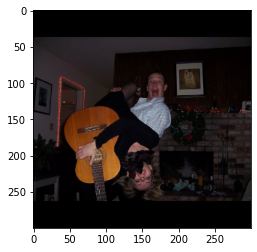

In [23]:
for images, targets in iter(dataloader):
    print(images.shape)
    print(type(targets))
    
    image = images[0].permute(1, 2, 0).numpy()
    target = targets[0]
    boxes = targets[0][:, :4]
    labels = targets[0][:, 4]    
    plt.imshow(image)
    plt.show()


    break

In [37]:
model = SSD300(21)
criterion = MultiboxLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e4)

Loaded pretrained model VGG to Base.


In [25]:
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print('Trainable params = ', trainable)
print('Total parmas = ', total)

Trainable params =  5570670
Total parmas =  26054574


In [44]:
train(dataloader, model, criterion, optimizer, 3)

------------------------------------------------------------
Epoch 1 / 3:
		 Time for iter: 1.9110229015350342 s, loss: 0.000000


KeyboardInterrupt: 